# An introduction to the Variational Quantum Eigensolver

> The goal of this homework is to become familiar with quantum circuits and hybrid quantum-classical algorithms through an example.



In this homework we will use the Variational Quantum Eigensolver (VQE) to find the ground state of an Ising Hamiltonian, following the steps

1. Initialization: construct a reference state
2. Parametrized quantum circuit: build a variational ansatz
3. Cost function: implement measurements
4. Classical optimization of the parameters

To obtain the final result, we iterate until convergence.

# Setup 

For this tutorial, we will use [Qiskit](https://www.ibm.com/quantum/qiskit), which is an IBM open-source python library for gate based quantum computing.

In order to install Qiskit, you need to use pip:

    !pip install qiskit
    !pip install qiskit-ibm-runtime

> Once this is installed, restart the kernel and you are ready to start!

To understand a bit better how to build circuits with Qiskit, a good idea is to check the [IBM Quantum Composer](https://quantum.ibm.com/composer/files/new). Open the link and go to _getting started_ -> _create your first circuit walkthrough_.

This will take you through the initial steps to build a Bell state and then measure it to see the probabilities. You should see that the probabilities are splitted $50\%$ in the state $\ket{00}$ and $50\%$ in the state $\ket{11}$. Make sure to choose the Qiskit option to see how the code is written.  

The resulting code should look as follows:


c:\Users\urtzi\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


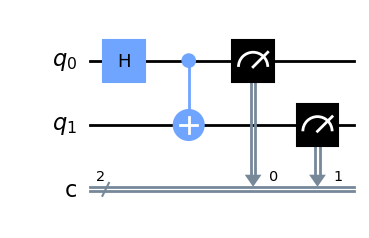

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.primitives import Sampler, Estimator #measuring can be done using Sampler or Estimator
from numpy import pi

qreg_q = QuantumRegister(2, 'q') # initialize the quantum register with number of qubits
creg_c = ClassicalRegister(2, 'c') # initialize classical register to measure
circuit = QuantumCircuit(qreg_q, creg_c) # composed circuit

circuit.h(qreg_q[0]) # add Hadamard gate
circuit.cx(qreg_q[0], qreg_q[1]) # add C-NOT gate
circuit.measure(qreg_q[0], creg_c[0]) # measure Qubit 1
circuit.measure(qreg_q[1], creg_c[1]) # measure Qubit 2

# draw the circuit
circuit.draw("mpl")

In [2]:
# check the output using the sampler
sampler = Sampler()
job = sampler.run(circuit)
probability_dists = job.result().quasi_dists # get prob distributions
print('The probability distribution is ', probability_dists)

The probability distribution is  [{0: 0.5, 3: 0.5}]


## The transverse field Ising model (TFIM)

Consider a chain of quantum spins. The state of each spin is given by $\alpha \ket{0} + \beta \ket{1}$, where $\alpha$ and $\beta$ are complex amplitudes, and it can be represented by a qubit (Bloch sphere).

The Hamiltonian of this system is given as follows:

$H = -\sum_{<i,j>} Z_i Z_j - h\sum_i X_i$,

where $Z_i$ is the Pauli matrix $Z$ applied to site $i$ and $X_i$ is the Pauli matrix $X$ applied to site $i$:

$X = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}$, 
$Z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}$. 

Note that the Pauli matrices and the tensor products between them are easily imported with Qiskit using

    from qiskit.quantum_info import SparsePauliOp
    X = SparsePauliOp('X')
    ZZ = SparsePauliOp('ZZ')

## Variational quantum eigensolver

We want to solve the Schrödinger equation $H\ket{\psi_0} = E_0\ket{\psi_0}$ to find the energy of the ground state. In particular, the Hamiltonian $H$ describes a system which minimizes the energy when all spins align to their neighbors in the $Z$ direction, but at the same time when the external field $h$ is finite, the spins want to align with the $X$ direction of the Bloch sphere. Since we have competing forces, finding the ground state can become a complex optimization problem.

In this tutorial we will use VQE, which relies on the variational principle

$E_0 \leq \frac{\bra{\psi} H \ket{\psi}}{\bra{\psi}\ket{\psi}}$.

The goal will be to minimize the energy of the ansatz state $\ket{\psi}$, which is given by $E = \bra{\psi} H \ket{\psi}$.

### Some references:

> [Here](https://learning.quantum.ibm.com/course/variational-algorithm-design) you can find most of the details about variational quantum algorithms discussed in the lectures exemplified using Qiskit.

> In [these](https://arxiv.org/pdf/2204.04198.pdf) notes on machine learning for physics there is a section where they introduce quantum algorithms and, in particular, VQE.

> To go a bit further, this [paper](https://arxiv.org/pdf/2012.09265.pdf) discusses the state of the art of variational quantum algorithms. 

## The task

### Step 1: Build the Hamiltonian

Start by importing numpy and matplotlib. From Qiskit you are going to need (for now) the Pauli operators 

    from qiskit.quantum_info import SparsePauliOp
    
Build the Hamiltonian for 3 qubits and different values of the external field $h$ (0.5,1 and 1.5). 
Note that you basically need to make a list of the operators with their corresponding coefficients, where each operator is a tensor product of some Paulis and identities everywhere else!

As a benchmark, run exact diagonalization on the Hamiltonian. An easy option is to convert the operator to a matrix using `hamiltonian.to_matrix()` and then use an eigensolver. Save the ground state energy and the ground state for each of the values of the external field.

In [5]:
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Pauli


def build_hamiltonian(h):
    hamiltonian = SparsePauliOp.from_list([("ZZI",-1),("IZZ",-1),("XII",h),("IXI",h),( "IIX",h)])
    return hamiltonian

hs = [0.5,1,1.5]
Hamiltonians = [build_hamiltonian(h) for h in hs]
hamiltonians_matrix = [h.to_matrix() for h in Hamiltonians]
# eigensolved = [LA.eigh(h) for h in hamiltonians_matrix]
# #print('The eigenvalues are ', eigensolved[0][0], eigensolved[1][0], eigensolved[2][0])
# print('Ground state energy is ', eigensolved[0][0][0], eigensolved[1][0][0], eigensolved[2][0][0])
# #print('The eigenvectors are ', eigensolved[0][1], eigensolved[1][1], eigensolved[2][1])
# print('Ground state is ', eigensolved[0][1][:,0], eigensolved[1][1][:,0], eigensolved[2][1][:,0])
# # Calculate ground state probability density
# ground_state_density = np.abs(eigensolved[0][1][:,0])**2
# print('Ground state probability density is ', ground_state_density)
eigenvalues = [LA.eigvalsh(h) for h in hamiltonians_matrix]
print('Ground state energy is ', eigenvalues[0][0], eigenvalues[1][0], eigenvalues[2][0])
for h in hamiltonians_matrix:
    eigenvectors = []
    _, eigenvectors = LA.eigh(h)
    ground_state = eigenvectors[:,0]
    print('Ground state is ', ground_state)
    ground_state_density = np.abs(ground_state)**2
    print('Ground state probability density is', ground_state_density)
    

Ground state energy is  -2.4032119259115525 -3.4939592074349353 -4.832414787762267
Ground state is  [ 0.63822335+0.j -0.19855627+0.j -0.11756599+0.j  0.19855627+0.j
 -0.19855627+0.j  0.11756599+0.j  0.19855627+0.j -0.63822335+0.j]
Ground state probability density is [0.40732905 0.03942459 0.01382176 0.03942459 0.03942459 0.01382176
 0.03942459 0.40732905]
Ground state is  [-0.53248075-0.j  0.29550452+0.j  0.20449548+0.j -0.29550452+0.j
  0.29550452+0.j -0.20449548+0.j -0.29550452+0.j  0.53248075+0.j]
Ground state probability density is [0.28353575 0.08732292 0.0418184  0.08732292 0.08732292 0.0418184
 0.08732292 0.28353575]
Ground state is  [ 0.47602776+0.j -0.3256814 +0.j -0.24750925+0.j  0.3256814 +0.j
 -0.3256814 +0.j  0.24750925+0.j  0.3256814 +0.j -0.47602776+0.j]
Ground state probability density is [0.22660243 0.10606837 0.06126083 0.10606837 0.10606837 0.06126083
 0.10606837 0.22660243]


In [29]:
import numpy as np
import scipy.linalg as LA

# Define a symmetric matrix
A = np.array([[1, 2], [2, 3]])

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = LA.eigh(A)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors)

Eigenvalues: [-0.23606798  4.23606798]
Eigenvectors: [[-0.85065081  0.52573111]
 [ 0.52573111  0.85065081]]


### Step 2: Build the ansatz (parametrized quantum circuit)

We can use different types of ansatz for our VQE.

One option is to use the two-local circuit defined [here](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal) to build an ansatz similar to the one we discussed in the lectures.

But feel free to explore any of the options [here](https://docs.quantum.ibm.com/api/qiskit/circuit_library#n-local-circuits). Note that you might want to use short circuits to get the optimization done.

Use `ansatz.decompose().draw("mpl")` to see the circuit.


c:\Users\urtzi\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


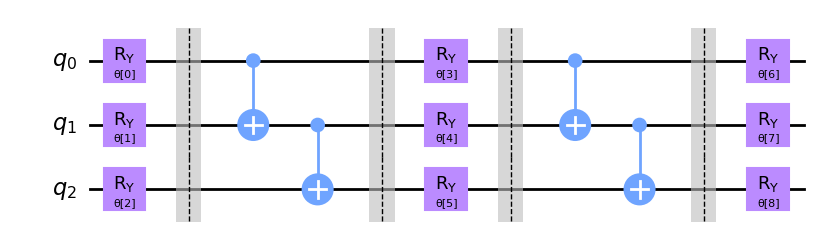

In [4]:
from qiskit.circuit.library import TwoLocal
def ansatz():
    return TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
ansatz().decompose().draw('mpl')


### Step 3: Define the classical optimizer 

Choose one of the [optimizers defined in qiskit](https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.optimizers) to run the classical optimization. Typical choices include SLSQP, COBYLA, SPSA, L_BFGS_B or ADAM. Explore a bit what are their characteristics (are they local or global, do they use the gradient or not, etc).
 

In [5]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import PauliExpectation, CircuitStateFn, StateFn, PauliOp
from qiskit.quantum_info import Pauli
 
ansatz = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
observable = Hamiltonians[0]
initial_point = np.random.random(ansatz.num_parameters)
 


def objective_function(x):
    bound = ansatz.bind_parameters(x)
    observable_op = sum(PauliOp(Pauli(pauli.to_label()), coeff) for coeff, pauli in zip(observable.coeffs, observable.paulis))
    
    state = CircuitStateFn(bound)
    expectation = PauliExpectation().convert(observable_op @ state)
    return np.real(expectation.eval().to_matrix()[0])



 
spsa = SPSA(maxiter=300)
result = spsa.optimize(ansatz.num_parameters, objective_function, initial_point=initial_point)

C:\Users\urtzi\AppData\Local\Temp\ipykernel_19172\2254254854.py:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA
C:\Users\urtzi\AppData\Local\Temp\ipykernel_19172\2254254854.py:25: DeprecationWarning: The method ``qiskit.algorithms.optimizers.spsa.SPSA.optimize()`` is deprecated as of qiskit-terra 0.21.0. It will be removed no earlier than 3 months after the release date. Instead, use ``SPSA.minimize`` as a replacement, which supports the same arguments but follows the interface of scipy.optimize and returns a complete result object containing additional information.
  result = spsa.optimize(ansatz.num_paramete

Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer. With this optimizer it is possible to optimize systems with multiple unknown parameters 

### Step 4: VQE without noise

Import the Estimator from the [qiskit_aer.primitives](https://docs.quantum.ibm.com/api/qiskit/primitives), which will allow us to simulate the circuit in our computer. 

> If we wanted to run it on a real device, we would need to import the primitives using [QiskitRuntimeService](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService). This allows us to acces the small devices in the [IBM Quantum platform](https://quantum.ibm.com/). If you want to check it an create an account, you have 10 minutes of computing time for free.

Set the estimator without noise and the number of shots used to compute the expectation values. Then, you can use the [VQE routine](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.VQE.html) to compute the minimum eigenvalue of the operator. Save the intermediate results and plot the value of the cost throughout the iterations to see how the algorithm converges.

> Before running the VQE, it is useful to fix the random seed 

        seed = 170
        algorithm_globals.random_seed = seed

Run it for different values of the external field (0.5, 1 and 1.5), and save the results.

In [6]:
from qiskit.primitives import Estimator
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
 
# h = 0.5

H1 = Hamiltonians[0]
psi1 = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
theta1 = np.random.uniform(0, 2*np.pi, 9)
job = Estimator().run([psi1],[H1],[theta1]) 
job_result = job.result()
print(f"The primitive-job finished with result {job_result}")

# h = 1

H2 = Hamiltonians[1] 
psi2 = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)  
theta2 = np.random.uniform(0, 2*np.pi, 9) 
job2 = Estimator().run([psi2],[H2],[theta2]) 
job_result2 = job2.result()
print(f"The primitive-job finished with result {job_result2}")

# h = 1.5

H3 = Hamiltonians[2]
psi3 = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
theta3 = np.random.uniform(0, 2*np.pi, 9)
job3 = Estimator().run([psi3],[H3],[theta3]) 
job_result3 = job3.result()
print(f"The primitive-job finished with result {job_result3}")




The primitive-job finished with result EstimatorResult(values=array([-0.03843166]), metadata=[{}])
The primitive-job finished with result EstimatorResult(values=array([-0.72565662]), metadata=[{}])
The primitive-job finished with result EstimatorResult(values=array([1.28711422]), metadata=[{}])


C:\Users\urtzi\AppData\Local\Temp\ipykernel_23460\2560038879.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA
C:\Users\urtzi\AppData\Local\Temp\ipykernel_23460\2560038879.py:25: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algori

The ground state energy is -2.44140625
The parameters for the circuit are  [ 2.98931678  5.64065109  4.68096341  5.56689933 -2.99484297  4.02256655
 -5.68280055 -6.11289123  3.05495268]


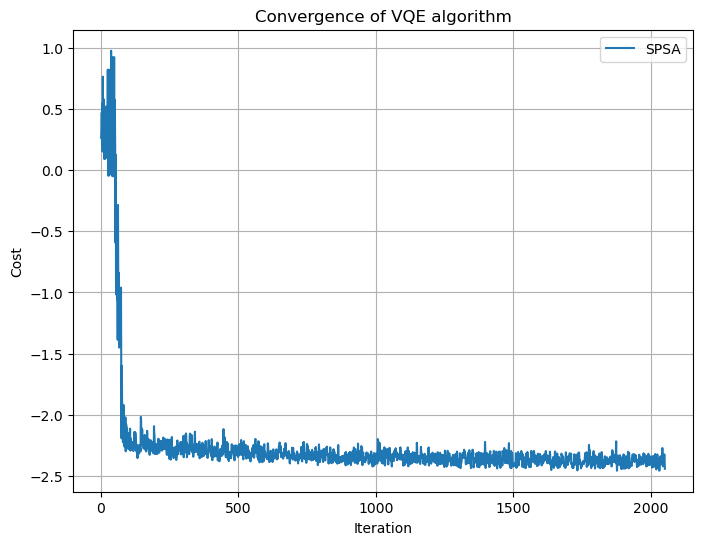

The ground state energy is -3.482421875
The parameters for the circuit are  [-4.96671468  5.44704419 -5.15507561 -5.06528088  0.60699994  6.48440271
 -2.32923361 -1.28561762 -3.26342844]


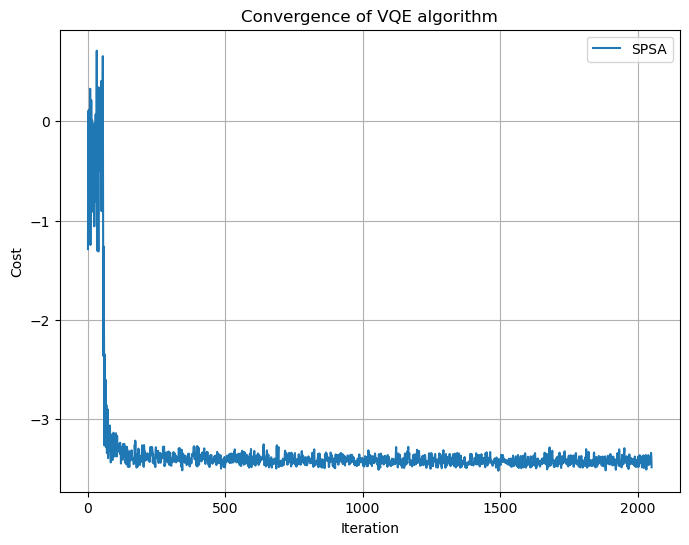

The ground state energy is -4.8515625
The parameters for the circuit are  [ 2.94879792 -6.45978954  2.3842678  -0.96067042 -1.25953631 -1.99290116
 -3.89636022 -0.5207682   5.85044769]


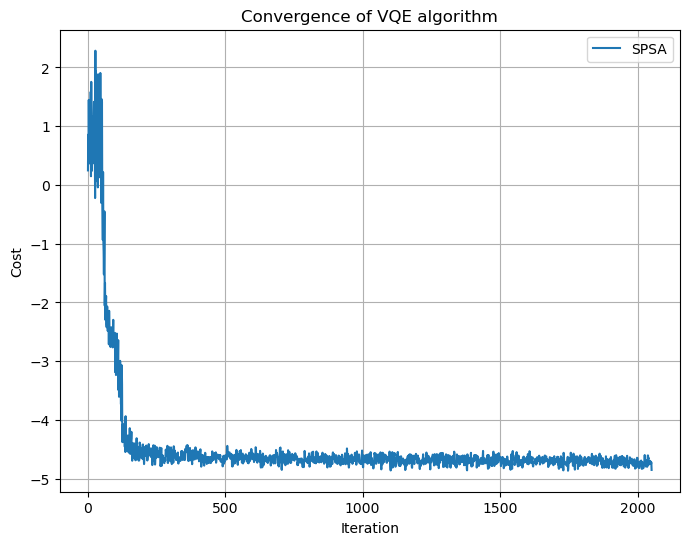

In [7]:

from qiskit_aer.primitives import Estimator 
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import PauliExpectation, CircuitStateFn, StateFn, PauliOp
from qiskit.quantum_info import Pauli
from qiskit_algorithms import VQE
from qiskit.utils import algorithm_globals
import matplotlib.pyplot as plt

shots = 1000
ansatz = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
spsa = SPSA(maxiter=shots)

counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

seed = 170
algorithm_globals.random_seed = seed
noiseless_estimator = Estimator(transpile_options={"seed_transpiler": seed},run_options={"seed": seed, "shots": 1024},)

vqe = VQE(noiseless_estimator, ansatz, spsa, callback=store_intermediate_result)
for j in range(3):
    result = vqe.compute_minimum_eigenvalue(Hamiltonians[j])
    print(f"The ground state energy is {result.eigenvalue.real}")
    print("The parameters for the circuit are ", result.optimal_point)
    plt.figure(figsize=(8, 6))
    plt.plot(counts, values, label="SPSA")
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Convergence of VQE algorithm')
    plt.legend()
    plt.grid()
    plt.show()
    counts = []
    values = [] 
    

## Errors:

In [8]:
  
err_1 = np.abs((-2.403211925911549-(-2.44140625))/-2.403211925911549 * 100)
print(f'The error of h = 0.5 is {err_1} %')

err_2 = np.abs((-3.493959207434927-(-3.482421875))/-3.493959207434927 * 100)
print(f'The error of h = 1 is {err_2} %')

err_3 = np.abs((-4.832414787762265-(-4.8515625))/-4.832414787762265 * 100)
print(f'The error of h = 1.5 is {err_3} %')

The error of h = 0.5 is 1.589303201962255 %
The error of h = 1 is 0.33020798898785386 %
The error of h = 1.5 is 0.39623486556296833 %



### Step 5: Study of the ground state for different values of h

Once the three simulations converged, save the optimal parameters for each of them.

Applying the ansatz circuit to the reference state $\ket{0}^{\otimes 3}$ with each of the optimal parameter vector, you will obtain the ground state. Using sampler (as shown before), look at the probability density of the ground states and compare them.

In [10]:
from qiskit.quantum_info import Statevector

#Parameters for h = 0.5
parameters_0 = [ 2.98931678,  5.64065109 , 4.68096341  ,5.56689933, -2.99484297 , 4.02256655,
 -5.68280055 ,-6.11289123 , 3.05495268]
# Parameters for h = 1
parameters_1 = [-4.96671468,  5.44704419, -5.15507561, -5.06528088,  0.60699994,  6.48440271,
 -2.32923361, -1.28561762 ,-3.26342844]
#Parameters for h = 1.5 
parameters_2 =[ 2.94879792, -6.45978954,  2.3842678,  -0.96067042, -1.25953631, -1.99290116,
 -3.89636022, -0.5207682,   5.85044769]

H1 = Hamiltonians[0]
psi1 = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
job = Estimator().run([psi1],[H1],[parameters_0]) 
job_result = job.result()
print(f"The primitive-job finished with result {job_result}")

final_state = psi1.assign_parameters(parameters_0)
final_state_vector = Statevector.from_instruction(final_state)
prob_densities = np.abs(final_state_vector.data)**2
print('The probability densities are ', prob_densities)

# h = 1

H2 = Hamiltonians[1] 
psi2 = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True) 
job2 = Estimator().run([psi2],[H2],[parameters_1]) 
job_result2 = job2.result()
print(f"The primitive-job finished with result {job_result2}")
final_state = psi2.assign_parameters(parameters_1)
final_state_vector = Statevector.from_instruction(final_state)
prob_densities = np.abs(final_state_vector.data)**2
print('The probability densities are ', prob_densities)

# h = 1.5

H3 = Hamiltonians[2]
psi3 = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
job3 = Estimator().run([psi3],[H3],[parameters_2]) 
job_result3 = job3.result()
print(f"The primitive-job finished with result {job_result3}")
final_state = psi3.assign_parameters(parameters_2)
final_state_vector = Statevector.from_instruction(final_state)
prob_densities = np.abs(final_state_vector.data)**2
print('The probability densities are ', prob_densities)





The primitive-job finished with result EstimatorResult(values=array([-2.35644531]), metadata=[{'shots': 1024, 'variance': 1.2972002029418945, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 3, 'num_clbits': 3, 'time_taken': 0.002001, 'sample_measure_time': 0.0003997, 'input_qubit_map': [[0, 0], [1, 1], [2, 2]], 'max_memory_mb': 3970, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 8, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': True, 'threshold': 14, 'max_fused_qubits': 5, 'applied': False}}, {'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 3, 'num_clbits': 3, 'time_taken': 0.0019682, 'sample_measure_time': 0.0003999, 'input_qubit_map

In [11]:
err_1 = np.abs((-2.403211925911549-(-2.31054688))/-2.403211925911549 * 100)
print(f'The error of h = 0.5 is {err_1} %')

err_2 = np.abs((-3.493959207434927-(-3.35546875))/-3.493959207434927 * 100)
print(f'The error of h = 1 is {err_2} %')

err_3 = np.abs((-4.832414787762265-(-4.86035156))/-4.832414787762265 * 100)
print(f'The error of h = 1.5 is {err_3} %')

The error of h = 0.5 is 3.8558832416080304 %
The error of h = 1 is 3.963711343287231 %
The error of h = 1.5 is 0.5781120509042897 %


### Step 6: VQE with noise

Now we will run the same simulations but adding a noise model from a fake device. We start by importing:

    from qiskit_aer.noise import NoiseModel
    from qiskit.providers.fake_provider import FakeVigo

Then we can define the device as `device=FakeVigo()` and take its coupling map `coupling_map = device.configuration().coupling_map` and the noise model `noise_model = NoiseModel.from_backend(device)`. Print the noise model to see its properties.

Once this is set, the AerEstimator can be defined to mimic the fake device and then we can run the algorithm as before, storing the results for different values of the external field.

C:\Users\urtzi\AppData\Local\Temp\ipykernel_19172\1099546954.py:33: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = seed


The ground state energy is -2.1025390625
The parameters for the circuit are  [ 6.84018381  7.58082109  4.94807578  8.13990274 -5.56375972  4.00848531
 -5.81507782 -6.3443581   3.06178619]


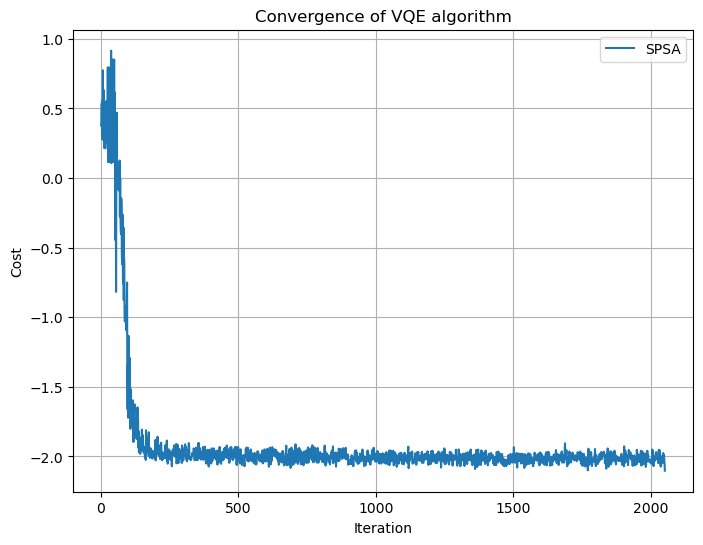

The ground state energy is -3.04296875
The parameters for the circuit are  [-5.41925108  5.39014527 -5.14975236 -5.41101254  0.40910415  6.67319839
 -2.00383513 -1.18790549 -3.25717989]


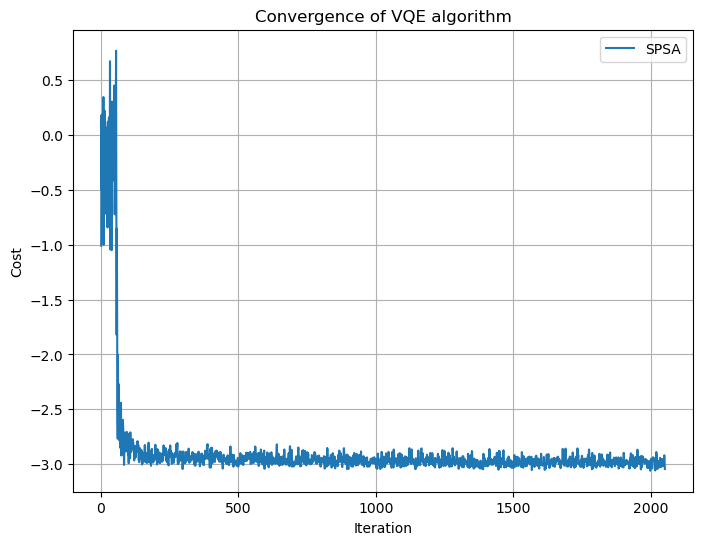

The ground state energy is -4.216796875
The parameters for the circuit are  [ 3.14565612 -6.40928547  2.46226232 -0.59339364 -1.17514561 -1.90661835
 -4.25024285 -0.50299812  5.97336904]


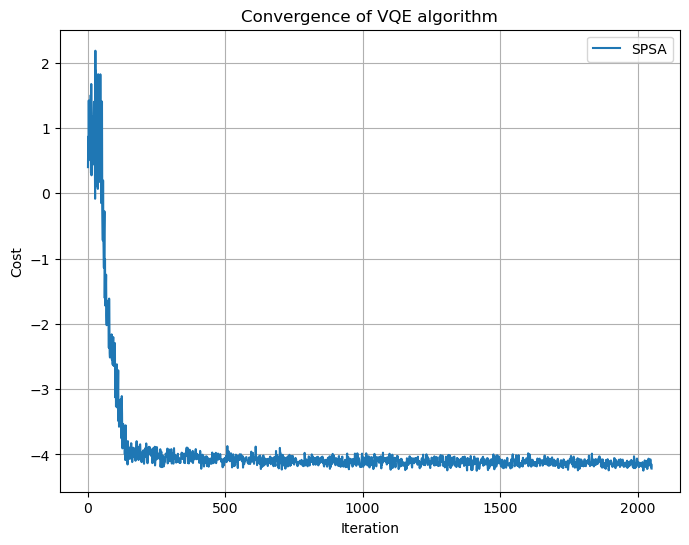

In [16]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

noisy_estimator = Estimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

counts = []
values = [] 

shots = 1000
ansatz = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
spsa = SPSA(maxiter=shots)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

seed = 170
algorithm_globals.random_seed = seed

vqe.estimator = noisy_estimator

for j in range(3):
    result = vqe.compute_minimum_eigenvalue(Hamiltonians[j])
    print(f"The ground state energy is {result.eigenvalue.real}")
    print("The parameters for the circuit are ", result.optimal_point)
    plt.figure(figsize=(8, 6))
    plt.plot(counts, values, label="SPSA")
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Convergence of VQE algorithm')
    plt.legend()
    plt.grid()
    plt.show()
    counts = []
    values = [] 


In [22]:
err_1 = np.abs((-2.403211925911549-(-2.1025390625))/-2.403211925911549 * 100)
print(f'The error of h = 0.5 is {err_1} %')

err_2 = np.abs((-3.493959207434927-(-3.04296875))/-3.493959207434927 * 100)
print(f'The error of h = 1 is {err_2} %')

err_3 = np.abs((-4.832414787762265-(-4.216796875))/-4.832414787762265 * 100)
print(f'The error of h = 1.5 is {err_3} %')

The error of h = 0.5 is 12.511292082470105 %
The error of h = 1 is 12.907719600024159 %
The error of h = 1.5 is 12.739343367652797 %


### Step 6: Report

Send us a report including:

- The definition of the TFIM Hamiltonian
- The ground state probability density and ground state energy obtained using exact diagonalization
- The convergence plots of the VQE with and without noise 
- Comparison between the energies obtained using VQE and the exact results
- The probability distribution of the ground states obtained without noise
    - Does it match the results from exact diagonalization?
    - Is this consistent with having two different phases? Which phases?

Send the report together with the code that you used to obtain and plot the results.
Remember that the code has to be understandable for the reviewers, so please be organized and insert comments!

> Bonus: If you have time, try to get the results for 5 qubits and more values of the external field in order to see the phase transition.
 

## TFIM HAMILTONIAN:

The Transverse Field Ising Model Hamiltonian is simple but important model in quanutm physics as it describes a systems of spins on a lattice. Although, we worked with 3 qubits, these systems are indeed quantum many body problems. Generally, the Hamiltonian can be written as:
  
$$ H=-J\sum_{i=1}^N\sigma_i^z\sigma_{i+1}^z - h\sum_{i=1}^N\sigma_i^x$$

Where the first term represents the neighboring interaction between spins. Thus, the sum goes over neighbor pairs of sins. Also, the $J$ coefficient refers to the interaction strength. In our case we chose $J=1$. In fact, the value of $J$ plays a crucial role as it defines the behavior of the system:

*  $J>0$ __Antiferromagnetic:__ The adjacent spins tend to align in opposite directions to minimize the energy, describing an antiferromagnetic interaction.
*  $J<0$ __Ferromagnetic:__ Ferromagnetic interaction between neighboring spins. In this case, adjacent spins tend to align in the same direction to minimize the energy.
*  $J=0$ __Critical Point:__ The behavior of the system will be dominated by the transverse field term.

Thus, as I just mentioned, the second term of the Hamiltonian refers to the transverse field term, representing an external magnetic field perendicular to the direction of spins, which in this case it is defined as z direction, thus, the magnetic firld applied through x direction will be represented with X Pauli $\sigma_x$ operators. The parameter $h$ represents the magnitude of the external field, thus, changing it, different behaviors should be observed.
 



## Exact diagonalization:

In the firs task, I defined the Hamiltonian and got the ground state energy and eigenvectors for three different values of h:

*  __h=0.5:__
GS Energy $\rightarrow -2.403211925911549$. For this value of h, looking at the ground state probability density values, [0.40732905, 0.03942459, 0.01382176, 0.03942459, 0.03942459, 0.01382176, 0.03942459, 0.40732905], we can check that the states with biggest probabilities are $|000\rangle$ and $|111\rangle$ with probabilities around $40\%$.

*  __h=1:__
GS Energy $\rightarrow -3.493959207434927$ and probability densities [0.28353575, 0.08732292, 0.0418184,  0.08732292, 0.08732292, 0.0418184, 0.08732292, 0.28353575]. Thus, we see that again the dominant states are $|000\rangle$ and $|111\rangle$ but with less probabilitiy $28\%$.

*  __h=1.5:__
GS Energy $\rightarrow -4.832414787762265$. Probability densities are given by [0.22660243, 0.10606837, 0.06126083, 0.10606837, 0.10606837, 0.06126083, 0.10606837, 0.22660243]. We can see that $|000\rangle$ and $|111\rangle$ are being less dominants. With higher values of h we should observe a phase transition.

## VQE without noise:

The algorithm without noise shows a convergence to the expected value. However, we can see that there is a small error in comparison with real eigenvalues:
* __Error h=0.5:__  1.589 %

* __Error h=1:__  0.33 %

* __Error h=1.5:__  0.396 %


Also, when getting the optimal parameters we can get the VQE eigenstates and compute the density probabilities:
* __h=0.5:__ [0.12366447, 0.02456614, 0.00285697, 0.05418546, 0.02609407, 0.01800645,
 0.0701429,  0.68048353]. In comparison with the exact computation, we observe hat even the most probable states are $|000\rangle$ and $|111\rangle$, the probability of measuring $|111\rangle$ is much higher $68 \%$ and $12\%$, respectively.

 * __h=1:__ [0.17541198, 0.06932069, 0.04209841, 0.10039543, 0.08381787, 0.04649507,
 0.11014801, 0.37231254]. Again, $|111\rangle$ has the greatest probability $37\%$ while for $|000\rangle$ $17.5\%$.

 * __h=1.5:__ [0.14097592, 0.10836147, 0.07581389, 0.10710471, 0.1173691,  0.06487978,
 0.11987479, 0.26562036]. The states are getting similar probabilites, although $|111\rangle$ remains the dominant, $26.56\%$.

 So we can check that, it is not completely consistent with the exact diagonalization..
## VQE witht noise:

We can observe that the error increases considerably when external noise is applies:

* __Error h=0.5:__  12.5 %

* __Error h=1:__  12.9 %

* __Error h=1.5:__  12.74 %


## Phases

So for small values of h we see there are clearly two dominant states $|000\rangle$ and $|111\rangle$. Realize, these are physically equivalent as in both states the three spins are pointing to the same direction. Thus, we could say we have an ordered structure. However, the bigger the h, we can observe that these states are losing relevance as they have less probabilities and other states start gaining importance. This could be understood as a phase transition towards a disordered state as any three qubit state can be measured. In fact, for very high values of h we should see how the probabilities are becoming the same (1/8) for every state. Realize that this way, we lose the order but we gain symmetry!